### Exploratory Data Analysis - Loan Offer Predictive Model
We'll begin by examining the SQL table we created in our Wrangling notebook. After making sure everything is in order, we'll explore the data in detail and prepare it for the next step, Pre-Processing.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing dataframe and inspecting the first few rows
with sqlite3.connect('bank.sqlite') as conn:
    df = pd.read_sql_query('SELECT * FROM clean_table', conn)

df.head()

,age,experience,income,zip,family,cc_avg,education,mortgage,personal_loan,securiities_account,cd_account,online,credit_card
0,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# Get the info for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  4948 non-null   int64  
 1   experience           4948 non-null   int64  
 2   income               4948 non-null   int64  
 3   zip                  4948 non-null   int64  
 4   family               4948 non-null   int64  
 5   cc_avg               4948 non-null   float64
 6   education            4948 non-null   int64  
 7   mortgage             4948 non-null   int64  
 8   personal_loan        4948 non-null   int64  
 9   securiities_account  4948 non-null   int64  
 10  cd_account           4948 non-null   int64  
 11  online               4948 non-null   int64  
 12  credit_card          4948 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 502.7 KB


In [4]:
# Set zip as character since zip code is non-ordinal
df['zip'] = df['zip'].astype(str)

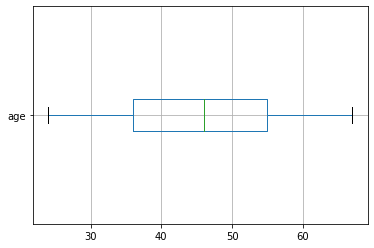

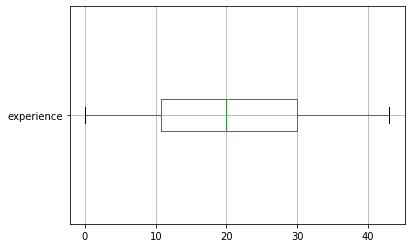

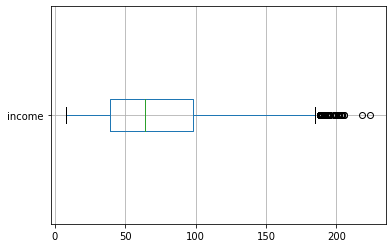

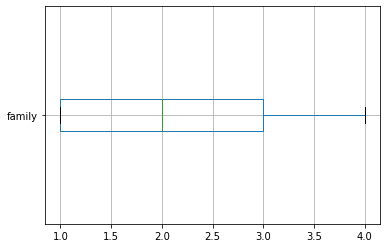

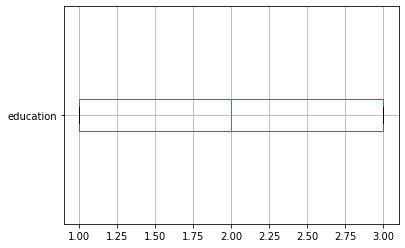

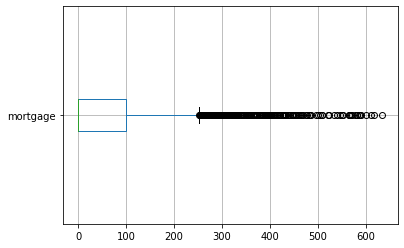

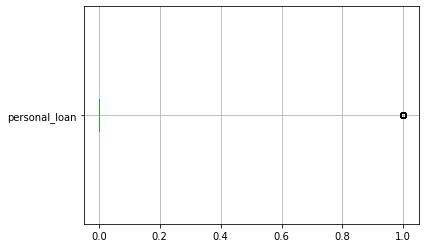

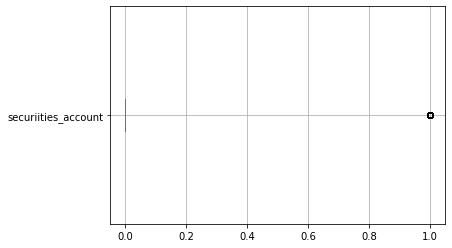

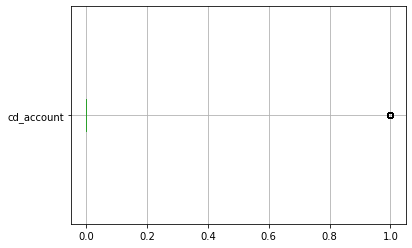

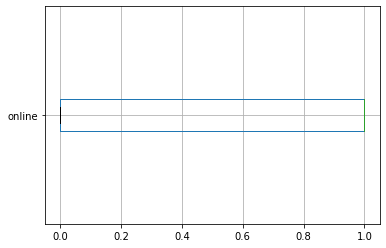

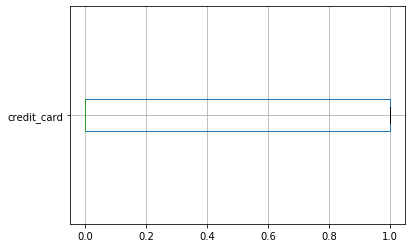

In [5]:
numeric_cols = df.select_dtypes(include='int64')
for i in numeric_cols:
    numeric_cols.boxplot(column=i, vert=False)
    plt.show()

We see income and mortgage are right-skewed, but there doesn't appear to be any dramatic outliers we need to address. Let's inspect a heatmap of the correlations to highlight any correlations worth digging into.

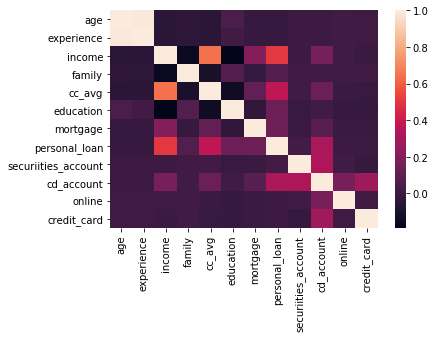

In [6]:
sns.heatmap(df.corr())

We see some positive correlation between age and experience, which is trivial. We also see positive correlation between cc_avg and income, personal_loan and income, as well as mortgage and income. Let's take a look at the pairplot of the non-binary features to visualize these relationships better.

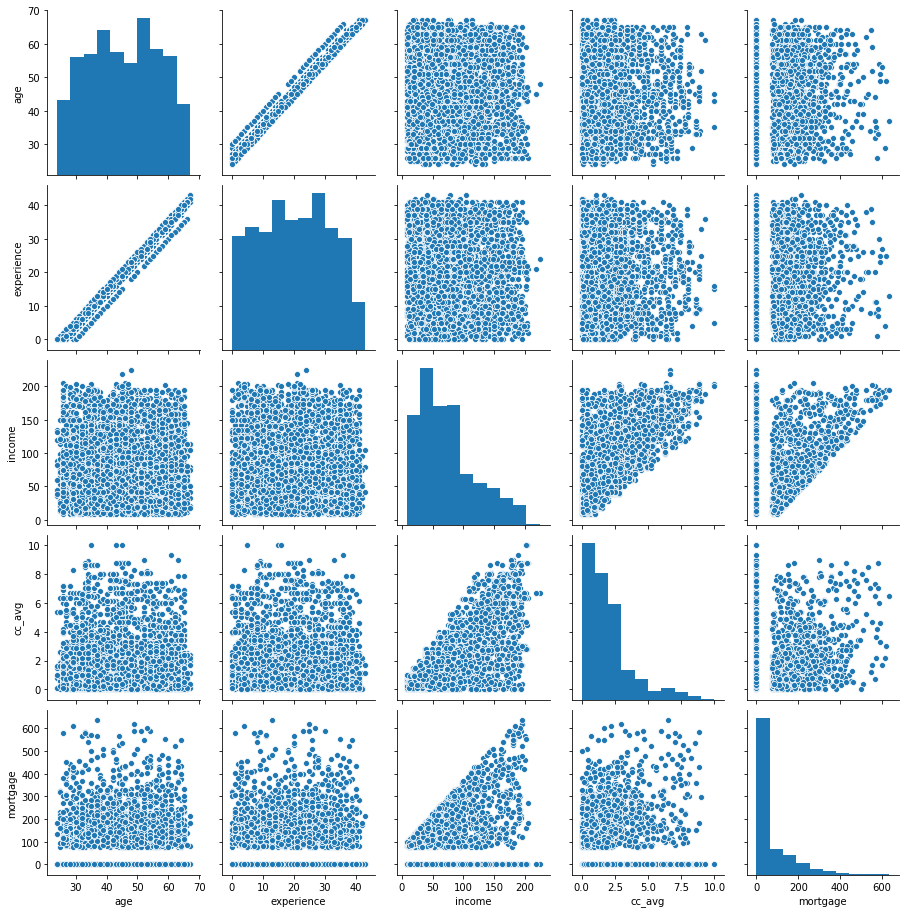

In [7]:
sns.pairplot(df[['age','experience','income','cc_avg','mortgage']])

Indeed, the relation between income and mortgage as well as income and cc_avg appears to be positive. It's a bit messy with all the data, so let's group income into 10 quantiles and see if the pattern is clearer between these quantiles and morgage/cc_avg.

In [8]:
# Begin by adding quantile feature to dataframe
bins = [0]
i = .1
while i <= .9:
    bins.append(df.income.quantile(i))
    i += .1

df['income_quantile'] = pd.cut(df.income, bins=bins, labels=('10','20','30','40','50','60','70','80','90'))

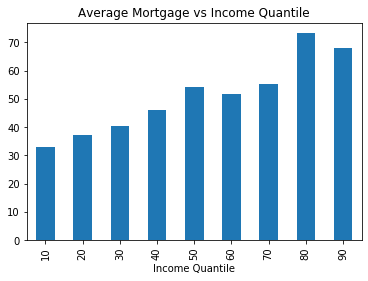

In [9]:
grouped_mortgage = df.groupby(df.income_quantile).mortgage.mean()
_ = grouped_mortgage.plot.bar()
_ = plt.xlabel('Income Quantile')
_ = plt.title('Average Mortgage')
_ = plt.title('Average Mortgage vs Income Quantile')

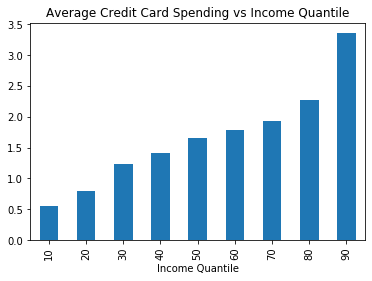

In [10]:
grouped_mortgage = df.groupby(df.income_quantile).cc_avg.mean()
_ = grouped_mortgage.plot.bar()
_ = plt.xlabel('Income Quantile')
_ = plt.title('Average Monthly Credit Card Spend')
_ = plt.title('Average Credit Card Spending vs Income Quantile')

Does ZIP code have any explanatory power over loan offer acceptance? Let's see the offers made ber ZIP code and percent of people who accepted the offer.

In [11]:
with sqlite3.connect('bank.sqlite') as conn:
    zip_offers = pd.read_sql_query('SELECT zip, COUNT(*) AS loan_offers, ROUND(AVG(personal_loan),2) AS loan_acceptance \
    FROM clean_table GROUP BY zip ORDER BY loan_acceptance DESC', conn)

zip_offers[:10]

,zip,loan_offers,loan_acceptance
0,96008,3,0.67
1,95135,3,0.67
2,94705,4,0.50
3,94108,4,0.50
4,92056,6,0.50
5,91129,2,0.50
6,90059,4,0.50
7,90016,2,0.50
8,93022,5,0.40
9,95192,3,0.33


Of the 10 zip codes that had the highest loan_acceptance, none received a significant number of offers.

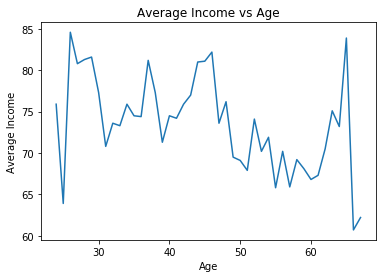

In [12]:
# What shape does average income take by age? Would expect it to be hump shaped with middle aged earning most
with sqlite3.connect('bank.sqlite') as conn:
    inc_by_age = pd.read_sql_query('SELECT age, ROUND(AVG(income),1) AS Mean_Income FROM clean_table GROUP BY age', conn)

plt.plot(inc_by_age['age'],inc_by_age['Mean_Income'])
_ = plt.xlabel('Age')
_ = plt.ylabel('Average Income')
_ = plt.title('Average Income vs Age')

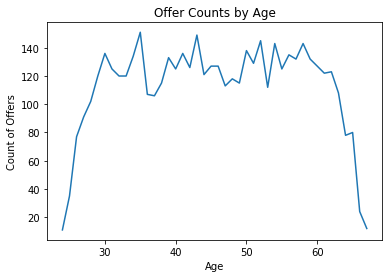

In [13]:
# Not quite the shape we'd expect, but it might also be worth looking at the count of recipients by age to see the distribution
with sqlite3.connect('bank.sqlite') as conn:
    offers_by_age = pd.read_sql_query('SELECT age, COUNT(*) AS Count FROM clean_table GROUP BY age', conn)

plt.plot(offers_by_age.age, offers_by_age.Count)
_ = plt.xlabel('Age')
_ = plt.ylabel('Count of Offers')
_ = plt.title('Offer Counts by Age')

We see significantly fewer offers made to those below 30 and thsoe above 60. Perhaps the lower quantity in these age groups help to explain the unexpected Average Income by Age plot from above.

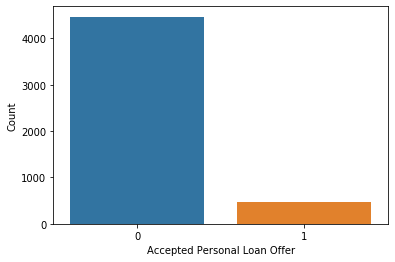

In [14]:
sns.countplot(x=df.personal_loan, data=df)
_ = plt.xlabel('Accepted Personal Loan Offer')
_ = plt.ylabel('Count')

In [15]:
df.personal_loan.value_counts()

0    4468
1     480
Name: personal_loan, dtype: int64

There are significantly fewer offers that were accepted than not, so this is a heavily skewed dataset.